In [1]:
import jellyfish
import urllib.request
import jsonlines
import gzip
import pandas as pd
import matplotlib.pyplot as plt
import itertools as it

GH_CORPUS_URL = "https://github-typo-corpus.s3.amazonaws.com/data/github-typo-corpus.v1.0.0.jsonl.gz"

In [2]:
def get_github_typo_data(url, languages):
    def extract_typos(commit):
        for edit in commit["edits"]:
            if edit["src"]["lang"] not in languages: continue
            if edit["tgt"]["lang"] not in languages: continue
            if "is_typo" not in edit: continue
            if not edit["is_typo"]: continue

            source = edit["src"]["text"]
            target = edit["tgt"]["text"]
            distance = jellyfish.damerau_levenshtein_distance(source, target)
            yield {"source": source, "target": target, "distance": distance}

    response = urllib.request.urlopen(url)
    with gzip.GzipFile(fileobj=response) as f:
        commits = jsonlines.Reader(f)
        typos = it.chain.from_iterable(extract_typos(commit) for commit in commits)
        df = pd.DataFrame(typos)

    return df

In [3]:
%%time
df = get_github_typo_data(GH_CORPUS_URL, languages={"eng"})

CPU times: user 1min, sys: 3.49 s, total: 1min 4s
Wall time: 1min 13s


Text(0.5, 0, 'Damerau-Levenshtein Distance')

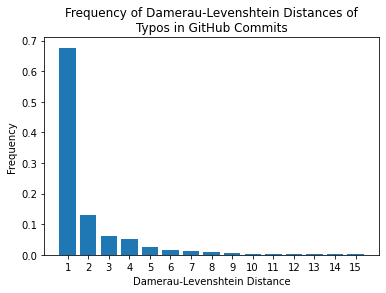

In [4]:
title = "Frequency of Damerau-Levenshtein Distances of\nTypos in GitHub Commits"
df.distance.plot(kind="hist", bins=range(1, 17), density=True, title=title, xticks=range(1, 16), align = "left", rwidth=0.8)
plt.xlabel("Damerau-Levenshtein Distance")